# Описание проекта

    Проект - анализ поведения пользователей мобильного приложения по продаже продуктов питания.

    Цели исследования: 
    
    - Изучение воронки продаж: сколько пользователей доходят до покупки в приложении и как они это делают; 
    что мешает остальным пользователям дойти до покупки;
    - Исследование результатов А/А/В эксперимента: как изменение шрифта в приложении повлияет на поведение
    пользователей; нужно ли менять шрифт или оставить прежний. 
    
    Ход исследования: 
    
    - Загрузка данных и подготовка к анализу
    - Предобработка данных.
    - Анализ данных и составление расчетов.
    - Общий вывод
    
# Описание данных

    Файл с данными: " /datasets/logs_exp.csv "
    
    - EventName — название события;
    - DeviceIDHash — уникальный идентификатор пользователя;
    - EventTimestamp — время события;
    - ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

## Загрузка данных и подготовка к анализу

In [1]:
import pandas as pd
import datetime as dt
import numpy as np
import math as mth
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
import warnings
register_matplotlib_converters()
import plotly.express as px
from plotly import graph_objects as go

In [2]:
data = pd.read_csv('/datasets/logs_exp.csv')
data.head()

,EventName\tDeviceIDHash\tEventTimestamp\tExpId
0,MainScreenAppear\t4575588528974610257\t1564029...
1,MainScreenAppear\t7416695313311560658\t1564053...
2,PaymentScreenSuccessful\t3518123091307005509\t...
3,CartScreenAppear\t3518123091307005509\t1564054...
4,PaymentScreenSuccessful\t6217807653094995999\t...


In [3]:
# Необходимо разделить данные
data = pd.read_csv('/datasets/logs_exp.csv', sep='\t')
data.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


## Предобработка данных 

In [5]:
# Заменим названия столбцов на более удобные

# data.columns=['event', 'user_id', 'event_ts', 'group']
data.rename(columns= {'EventName':'event', 'DeviceIDHash':'user_id', 'EventTimestamp':'event_ts', 'ExpId':'group'}, inplace=True) 
data.head()

,event,user_id,event_ts,group
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [6]:
# Проверка на пропуски
data.isna().sum()

event       0
user_id     0
event_ts    0
group       0
dtype: int64

    Пропусков нет

In [7]:
# Проверка на дубликаты
data.duplicated().sum()

413

    Кол-во дубликатов = 413. Возможно это технические ошибки выгрузки, так как время указано вплоть до секунд. Вряд ли один и тот же пользователь в ту же секунду совершил одно и то же действие. Удалим дубликаты методом drop_duplicates.

In [8]:
data.drop_duplicates(inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243713 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   event     243713 non-null  object
 1   user_id   243713 non-null  int64 
 2   event_ts  243713 non-null  int64 
 3   group     243713 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 9.3+ MB


    Также следует проверить, нет ли у нас пользователей, находящихся одновременно в разных группах

In [9]:
count_groups = data.groupby('user_id')['group'].nunique()
count_groups
data = data.merge(count_groups, on=['user_id'])
#data.head()
data.rename(columns = {'group_x':'group', 'group_y':'group_count'}, inplace = True)
#data.head()
data.query('group_count!=1').count()

event          0
user_id        0
event_ts       0
group          0
group_count    0
dtype: int64

In [10]:
# Добавим столбец даты и времени, а также отдельный столбец дат
data['event_dt'] = pd.to_datetime(data['event_ts'], unit='s')
data.head()

,event,user_id,event_ts,group,group_count,event_dt
0,MainScreenAppear,4575588528974610257,1564029816,246,1,2019-07-25 04:43:36
1,MainScreenAppear,4575588528974610257,1564633800,246,1,2019-08-01 04:30:00
2,MainScreenAppear,4575588528974610257,1564888031,246,1,2019-08-04 03:07:11
3,OffersScreenAppear,4575588528974610257,1564888070,246,1,2019-08-04 03:07:50
4,MainScreenAppear,4575588528974610257,1564888143,246,1,2019-08-04 03:09:03


In [11]:
data['date'] = data['event_dt'].dt.date
data.head()

,event,user_id,event_ts,group,group_count,event_dt,date
0,MainScreenAppear,4575588528974610257,1564029816,246,1,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,4575588528974610257,1564633800,246,1,2019-08-01 04:30:00,2019-08-01
2,MainScreenAppear,4575588528974610257,1564888031,246,1,2019-08-04 03:07:11,2019-08-04
3,OffersScreenAppear,4575588528974610257,1564888070,246,1,2019-08-04 03:07:50,2019-08-04
4,MainScreenAppear,4575588528974610257,1564888143,246,1,2019-08-04 03:09:03,2019-08-04


In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243713 entries, 0 to 243712
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   event        243713 non-null  object        
 1   user_id      243713 non-null  int64         
 2   event_ts     243713 non-null  int64         
 3   group        243713 non-null  int64         
 4   group_count  243713 non-null  int64         
 5   event_dt     243713 non-null  datetime64[ns]
 6   date         243713 non-null  object        
dtypes: datetime64[ns](1), int64(4), object(2)
memory usage: 14.9+ MB


## Анализ данных и составление расчетов.


### Изучение и проверка данных  

In [13]:
# Посчитаем, сколько всего событий в логе
len(data['event'])

243713

In [14]:
# Сколько всего уникальных событий в логе
display(data['event'].nunique())
data['event'].unique()

5

array(['MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear',
       'PaymentScreenSuccessful', 'Tutorial'], dtype=object)

In [15]:
# Сколько всего пользователей в логе
data['user_id'].nunique()

7551

In [16]:
# Сколько в среднем событий приходится на пользователя?
user_events = data.groupby('user_id'
                          ).agg({'event_ts':'count'}
                               ).sort_values(by='event_ts',ascending=False
                                            ).reset_index()

display(user_events['event_ts'].median())
user_events['event_ts'].describe()


20.0

count    7551.000000
mean       32.275593
std        65.154219
min         1.000000
25%         9.000000
50%        20.000000
75%        37.000000
max      2307.000000
Name: event_ts, dtype: float64

In [17]:
# Данными за какой период вы располагаете? Найдите максимальную и минимальную дату.
display(data['event_dt'].min())
data['event_dt'].max()

Timestamp('2019-07-25 04:43:36')

Timestamp('2019-08-07 21:15:17')

    У нас имеется лог, в котором записаны 243 713 событий. Всего у нас 5 типов событий:
    - "MainScreenAppear" - главная страница;
    - "OffersScreenAppear" - страница предложений (каталог);
    - "CartScreenAppear" - страница корзины;
    - "PaymentScreenSuccessful" - страница успешной оплаты; 
    - "Tutorial" - обучающая страница как оформить покупку товара
    
    Все записи лога зафиксированы в промежутке с '2019-07-25 04:43:36' по '2019-08-07 21:15:17'.
    За этот период мобильное приложение посетил 7551 пользователь. 
    В среднем на одного пользователя приходится 32 события (медиана = 20 событий).
    

   ### Определение корректных данных. Отсеивание старых записей

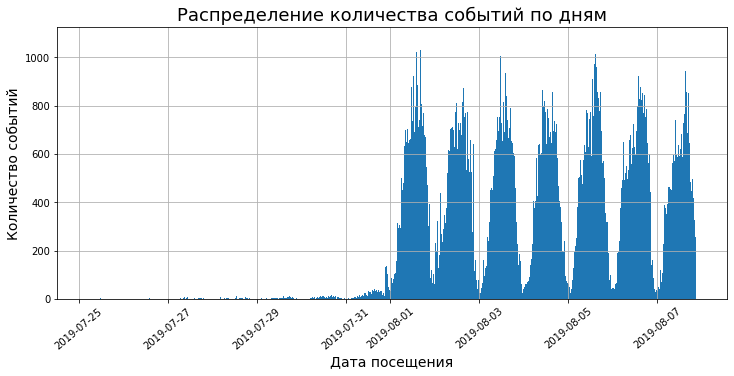

In [19]:
# Гистограмма по дате и времени. 
data['event_dt'].hist(bins=1000, figsize=(12,5))
plt.xticks(rotation=40)
plt.xlabel('Дата посещения', fontsize=14)
plt.ylabel('Количество событий', fontsize=14)
plt.title('Распределение количества событий по дням', fontsize=18)
plt.show(block=False)

    По графику распределения видно, что у нас неполные данные с 25 июля до 01 августа 2019. 
    Скорее всего, подобный "перекос" данных связан с тем, что в логи по некоторым пользователям попали события из прошлого. 
    Таким образом, мы можем анализировать данные с 1 августа 2019 года.

In [ ]:
# Отбросим неполные старые данные
good_data = data.query('event_dt >= "2019-08-01"')

# Сколько событий и пользователей потерялось при урезании данных
event_delta = len(data['event_dt']) - len(good_data['event_dt'])
users_delta = data['user_id'].nunique() - good_data['user_id'].nunique()

display("Количество потерянных событий:", event_delta)
display('Количество потерянных пользователей:', users_delta)

In [ ]:
display((len(data['event_ts']) - len(good_data['event_ts'])) / len(data['event_ts'])*100)
(len(data['user_id'].unique()) - len(good_data['user_id'].unique())) / len(data['user_id'].unique())*100

    При урезании потеряли всего 1,16% данных и 0,225% пользователей

In [ ]:
# Посчитаем количество пользователей в экспериментальных группах
display(data.groupby('group').agg({'user_id':'nunique'}).sort_values(by='user_id'))
good_data.groupby('group').agg({'user_id':'nunique'}).sort_values(by='user_id')

    Из 17 "потерянных" пользователей по 5 человек было из 246 и 248 группы, 7 человек из 247-й. 
    В новых данных разбивка пользователей на группы эксперимента 246, 247 и 248 слабо изменилась.

### Изучение воронки событий  

In [ ]:
# Какие события есть в логах, как часто они встречаются. 

event_funnel = good_data.groupby('event'
                              ).agg({'event_dt':'count'}
                                   ).sort_values(by='event_dt', ascending=False
                                                ).reset_index()
event_funnel


In [ ]:
# Количество событий ежедневно 
daily_events = good_data.pivot_table(index=['date', 'event'], values='event_dt', aggfunc='count')
daily_events.tail(10)

In [ ]:
# Сколько пользователей совершали каждое из возможных событий. 
# События по числу пользователей. 

event_users = good_data.groupby('event'
                          ).agg({'user_id':'nunique'}
                               ).sort_values(by='user_id', ascending=False
                                            ).reset_index()
daily_users = data.pivot_table(index=['date', 'event'], values='user_id', aggfunc='nunique')

display(event_users)
daily_users.tail(10)

In [ ]:
# Доля пользователей, которые хоть раз совершали событие
event_users = good_data.groupby('event').agg({'user_id':'nunique'}).reset_index().sort_values(by='user_id', ascending=False)
event_users.columns=['event', 'users']
event_users['ratio'] = (event_users['users'] / data['user_id'].nunique()).round(3)
event_users

In [ ]:
# Доля пользователей, которые совершили только одно событие
users = good_data.groupby('user_id').agg({'event_dt':'nunique'}).reset_index()
one_time_users = round(len(users[users['event_dt']==1])/len(users['user_id'])*100, 2)
display(len(users[users['event_dt']==1]))
one_time_users


        На главную страницу попали 98,3% пользователей, страницу с каталогом открыли 61% пользователей, 
    корзину открыли 49,5% пользователей, страницу успешной оплаты увидели 47% пользователей. Инструкцию открыло 
    всего 11,1% пользователей. 119 человек (1,58% пользователей) совершили только одно событие из 5 возможных.
        Далеко не все пользователи заходят на главную страницу. Возможно, они уходят на этапе туториала. 
    Таким образом, первым шагом в воронке событий может быть туториал, однако поскольку его проходят далеко не все,
    нерационально его включать в воронку. Так, в качестве первого шага рассматриваем появление главной страницы; 
    второй шаг - страница с предложениями (каталогом); третий шаг - корзина; четвёртый (последний) шаг - 
    страница об успешной оплате. Исключим страницу с инструкцией из воронки событий.   

In [ ]:
# Данные для построения воронки событий 
funnel_data = good_data.query('event!="Tutorial"')
good_funnel = funnel_data.groupby('event'
                                 ).agg({'event_dt':'count'}
                                      ).sort_values(by='event_dt', ascending=False
                                                   ).reset_index()
good_funnel

In [ ]:
# График воронки
fig = go.Figure(
    go.Funnel(
        y=good_funnel['event'],
        x=good_funnel['event_dt'],
        textinfo = "value+percent initial+percent previous",
    )
)
fig.show() 

In [ ]:
# Воронка по дням
daily_funnel = funnel_data.pivot_table(index='event', columns='date', values='event_dt', aggfunc='count').reset_index()
daily_funnel.columns = daily_funnel.columns.astype(str)
daily_funnel.sort_values(by='2019-08-01', ascending=False)


In [ ]:
# Воронка по количеству пользователей
funnel_users = funnel_data.groupby('event'
                                  ).agg({'user_id':'nunique'}
                                       ).sort_values(by='user_id', ascending=False
                                                    ).reset_index()
funnel_users

In [ ]:
# Какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем)
fig = go.Figure(
    go.Funnel(
        y=funnel_users['event'],
        x=funnel_users['user_id'], 
        textinfo = "value+percent initial+percent previous")
)
fig.show() 

    На втором шаге мы теряем больше всего пользователей 38%. Возможно есть какая-то проблема на первом шаге, 
    которая мешает/усложняет/отпугивает пользователей - надо об этом сообщить тестировщикам и выяснить причину. 
    От первого этапа до этапа оплаты, доходит 48% пользователей, это неплохой показатель. 
    В основном те люди, которые добавили товар в корзину и перешли на страницу с корзиной, то есть на третий этап, 
    оплачивают товар на последнем этапе - 95%.

## Изучение результатов эксперимента

### Анализ количества пользователей в экспериментальных группах

In [ ]:
# Количество пользователей в каждой экспериментальной группе
group_count = good_data.groupby('group')['user_id'].nunique()
group_count

    Группы распределены почти равномерно: 2 484 пользователя в 246 группе, 2 513 пользователей в 247 группе, 
    и в 248 группе 2 537 пользователей.

In [ ]:
# Наиболее часто встречающееся событие
events = funnel_data.groupby('event').agg({'event_dt':'nunique'}).sort_values(by='event_dt', ascending=False).reset_index()
main_event = good_funnel.merge(funnel_users, on='event')
main_event.columns = ['event','events_count', 'users_count']
group_users = funnel_data.pivot_table(index='event', columns='group', values='user_id', aggfunc='nunique'
                                     ).sort_values(by=246, ascending=False).reset_index()
test_pivot = main_event.merge(group_users, on='event')
test_pivot

    Наиболее часто встречающееся событие - это открытие главной страницы (117 328 событий у 7419 пользователей). 

### Статистическое исследование разницы между выборками
 
Перед тем как начать A/B-тест надо убедиться что:
- на результаты не влияют аномалии и выбросы в генеральной совокупности;
- инструмент «деления» трафика работает безошибочно;
- данные отправляются в системы аналитики корректно.

Для этого проводят A/A-тест. Он похож на A/B-тест, только группам показывают не разные, а одинаковые версии страниц.Если трафик и инструмент проведения A/A-теста не подвели, различий в показателях не будет. Ещё А/А-тест помогает определить длительность теста и методику анализа данных.

Критерии успешного A/A-теста:

- Количество пользователей в различных группах различается не более, чем на 1%;
- Для всех групп фиксируют и отправляют в системы аналитики данные об одном и том же;
- Различие ключевых метрик по группам не превышает 1% и не имеет статистической значимости;
- Попавший в одну из групп посетитель остаётся в этой группе до конца теста. Если пользователь видит разные версии исследуемой страницы в ходе одного исследования, неизвестно, какая именно повлияла на его решения. Значит, и результаты такого теста нельзя интерпретировать однозначно.

    
Степень различия ключевых метрик по группам зависит от необходимой чувствительности эксперимента. Скажем, если вы хотите определить результаты теста, в котором ожидаете не менее 30% прироста, то 10% погрешности измерений вас устроят. Однако такое бывает редко: изменение показателей на 30% обычно заметно и без A/B-теста. Его применяют там, где степень различия между группами не больше 10%, или же подвержены колебаниям. В таких случаях точность A/A-теста в 1% — распространённый критерий.     

In [ ]:
# Добавим колонку для последущего анализа экспериментальных групп 
group_count['246+247'] = group_count[246] + group_count[247]

test_pivot['246+247'] = test_pivot[246] + test_pivot[247]
test_pivot['246_ratio'] = (test_pivot[246]/group_count[246]).round(3)
test_pivot['247_ratio'] = (test_pivot[247]/group_count[247]).round(3)
test_pivot['248_ratio'] = (test_pivot[248]/group_count[248]).round(3)
test_pivot['246+247_ratio'] = (test_pivot['246+247']/(group_count['246+247'])).round(3)
test_pivot

#### А/А-тест (группа 246 / группа 247)
    Проанализируем по две выборки для каждого из четырёх событий в группе 246 и в группе 247.

    Сформулируем нулевую гипотезу H0: Доли двух выборок равны между собой. 
    Альтернативная гипотеза H1: Доли двух выборок не равны между собой.

    Проверим гипотезы через z-критерий. Введём уровень значимости alpha равный 1%.

In [ ]:
# Нулевая гипотеза H0: Доли двух выборок равны между собой. 
# Альтернативная гипотеза H1: Доли двух выборок не равны между собой.

alpha = .01 # критический уровень статистической значимости
def z_test(group_1, group_2, alpha):
    for i in test_pivot.index:
        p1 = test_pivot[group_1][i] / group_count[group_1]
        # пропорция успехов во второй группе:
        p2 = test_pivot[group_2][i] / group_count[group_2]
        # пропорция успехов в комбинированном датасете:
        p_combined = ((test_pivot[group_1][i] + test_pivot[group_2][i]) / 
                      (group_count[group_1] + group_count[group_2]))
        # разница пропорций в датасетах
        difference = p1 - p2
        # считаем статистику в ст.отклонениях стандартного нормального распределения
        z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * 
                                        (1/group_count[group_1] + 1/group_count[group_2]))
        # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
        distr = st.norm(0, 1) 
        p_value = (1 - distr.cdf(abs(z_value))) * 2
        print('{} p-значение: {}'.format(test_pivot['event'][i], p_value))
        if (p_value < alpha):
            print("Отвергаем нулевую гипотезу: между долями есть значимая разница")
        else:
            print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными")
        print('')
        
z_test(246, 247, alpha)

    Исходя из того, что все A/A-тесты показали отсутствие статистически значимых различий долей пользователей, совершивших события, по каждому из событий, мы можем сделать вывод о том, что разбиение на группы работает корректно

#### A/B-тест 

    Так как для A/B теста не нужна высокая точность, то для дальнейших экспериментов выберем самый стандартный уровень
    значимости равный 5%. Дальше проведем еще 3 группы тестов: 246/248, 247/248, 246+247/248. 
    Сравнения также проведём по каждому из событий. 

In [ ]:
# 246/248
alpha = 0.05
z_test(246, 248, alpha)

In [ ]:
# 247/248
z_test(247, 248, alpha)

In [ ]:
# 246+247/248
z_test('246+247', 248, alpha)

    Исходя из того, что все A/B-тесты показали отсутствие статистически значимых различий долей пользователей, совершивших
    события, по каждому из событий, мы можем сделать вывод о том, что изменения, которые были осуществлены в B-тесте 
    не имеют существенного влияния на изменение долей. Практически за неделю экспериментов с новым шрифтом не наблюдалось
    изменений в показателях поведения потребителей - пользователи моментально адаптировались к новому шрифту.

## Общие выводы

Было проведено исследование поведения пользователей мобильного приложения, разработанного стартапом, который продаёт продукты питания на основе логов в приложении. В логах рассматривается 243 713 событий. При этом существует 5 вариантов событий:

- MainScreenAppear - появление главного экрана (главной страницы);
- OffersScreenAppear - появление экрана с предложениями (каталог товаров);
- CartScreenAppear - появление экрана с корзиной товаров;
- PaymentScreenSuccessful - экран об успешной оплате;
- Tutorial - ознакомление с инструкцией.

В логах представлены данные о 7 551 пользователе. При этом для них имеется очень большой разброс в количестве событий: от 1 до 2 307 за весь рассматриваемый период. Среднее значение составляет 32 события, а медианное значение - 20 событий. Поскольку распределение не является нормальным, рациональнее в качестве средней использовать медиану. Таким образом, в среднем, на каждого пользователя приходится около 20 событий за рассматриваемый период.

У нас имеется 3 группы экспериментов: 246 и 247 - контрольные группы, а 248 - экспериментальная группа. Это группы, на основе которых проводилось A/A/B-тестирование. В группе эксперимента номер 246 представлено 2 489 пользователей. В группе 247 - 2 520 пользователей, а в группе 248 - 2 542 пользователя.

Данные представлены за период с 04:43 25 июля по 21:15 7 августа 2019 года. По распределению количества пользователей для каждого события по дате и времени начала мы изучили, насколько имеющиеся данные являются полными. Оказалось, что у нас неполные данные до 01.08.2019. Скорее всего, подобный "перекос"связан с тем, что в логи по некоторым пользователям попали события из прошлого. Таким образом, производился анализ "усечённых" данных: с 1 августа по 7 августа 2019 года. В логах актуальных данных осталось 240 887 событий, то есть было отброшено всего 1,16% данных по событиям. Актуальные данные включают в себя логи по 7 534 пользователям, то есть было отброшено всего 0,23% данных по пользователям. Из "отброшенных" пользователей все они были из разных групп, соответственно, в новых данных разбиение пользователей на группы эксперимента 246, 247 и 248 слабо изменилось.

Анализ данных позволил сделать следующие выводы:

1) Наиболее часто встречающееся событие - это открытие главной страницы (оно появляется в логах 117 328 раз), далее - появление страницы с каталогом товаров (46 333 события). На третьем месте по частоте возникновения - страница с корзиной (42 303 события). Далее - экран об успешной оплате (33 918 событий). На последнем месте по частоте возникновения событий находится ознакомление с инструкцией (туториал): всего 1 005 событий. Это может указывать на то, что не каждому пользователю для совершения всех шагов до оплаты нужен туториал

2) Места по количеству пользователей для каждого события распределились так же, как и по частоте возникновения событий. На главную зашло 7 419 пользователей; страницу с каталогом открыли 4 593 пользователя; экран с корзиной появился у 3 734 пользователей и экран с успешной оплатой - у 3 539 пользователей. Инструкцию открывало 840 пользователей. Шаг "появление главной страницы" прошли 98,5% пользователей, страницу с предложениями прошло 61% пользователей, корзину открыли 49,6% пользователей, экран об успешной оплате увидели 47% пользователей. Инструкцию открыло только 11,1% пользователей.

    Отметим, что далеко не все пользователи заходят на главный экран. Возможно, они уходят на этапе туториала. Таким образом, первым шагом в воронке событий может быть туториал, однако поскольку его проходят далеко не все, нерационально его включать в воронку. Так, в качестве первого шага рассматриваем появление основной страницы; второй шаг - каталог; третий шаг - корзина; четвёртый (последний) шаг - страница об успешной оплате. Соотвтетственно из анализа воронки событий был исключен страница с инструкцией.

3) С главного экрана на выбор продуктов переходит 61,9%. На следующем шаге уходит меньшее число пользователей: в корзину переходит 81,3% пользоателей, открывших каталог. И после корзины 94,8% пользователей совершает оплату. Всего 47.7% пользователей доходит от первого события до оплаты.

    Соответственно, самым "сложным" шагом для пользователей является переход на второй этап - страницу с товарами.

4) Все группы распределены почти равномерно: в 246 группе 2 484 пользователя (33% от всех пользователей); в 247 группе 2 513 пользователей (33,4% от всех); в 248 группе 2 537 пользователей (33,7% от общего числа). В целом, данные в рамках суток распределены нормально с небольшими смещениями в отдельные дни. 

5) Для определения, насколько значимы различия между выборками, был проведён статистический тест по z-критерию. В ходе тестирования были проведены 16 экспериментов:
    - 246/247 - 4 эксперимента (для каждого события) / уровень статистической значимости - 1%
    - 246/248 - 4 эксперимента (для каждого события) / уровень статистической значимости - 5%
    - 247/248 - 4 эксперимента (для каждого события) / уровень статистической значимости - 5%
    - 246+247/248 - 4 эксперимента (для каждого события) / уровень статистической значимости - 5%
    
    Так как группы A1/A2 должны быть одинаковыми, то над ними и контроль жестче. Поэтому для проведения A/A тестирования был взят уровень статистической значимости равный 1%. Для остальных А/В-тестов был выбран уровень статистической значимости равный 5%.

В результате всех и каждого A/A/B эксперимента значимой разницы между группами не выявлено. Разбиение на группы работает корректно и практически за неделю экспериментов с новым шрифтом не наблюдалось изменений в показателях поведения потребителей - пользователи моментально адаптировались к новому шрифту.

Рекомендации:

1) Следует пересмотреть инструкцию - упростить переход к ней/от нее, изменить оформление и т.п.;

2) Необходимо изучить проблемы с переходом от главной страницы на выбор предложений. Проблемы могут быть связаны как с техническими неполадками, так и с дизайном приложения или интуитивной "понятностью" перехода по страницам.    